# 24th July:

Checking what is going with the ranks of the matrices.

Done:
- [x] rank(odd) = 2*rank(lnn)
- [x] rank(even) = rank(lnn)

Problem:
- [ ] rank(full) $\neq$ rank(odd) * rank(even) * rank(odd)
- The rank might not necessarily be the same because we have a $\mathcal{O(dt^3)}$ error in the second order troter. HOWEVER, the problem is that not even the rank of exp(odd) @ exp(even) @ exp(odd) is the same!

Ideas:

- check how the rank changes when changing: $\gamma$ and $\tau$
- the rank of the approx and the full lvec do seem to coincide tho ... do the ranks not just simply multiply?
- the issue might be the tolerance that I use. how do i know which ones are numeric noise and which ones do actually contributed? should they be relative to the norm of the operator? CHECK NORMS
- check the rank of the matrices that I get when optimizing through GSD: X1, X2, X3


In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt

initial: 2.638300722408311e-07
final: 2.0772161170510943e-07


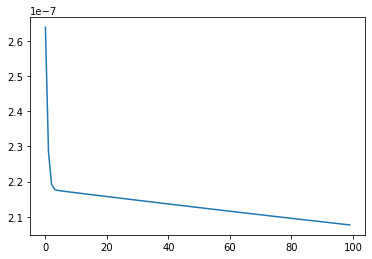

In [2]:
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi, create_trotter_layers, lindbladian2super
from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss

d, N = 2, 4
dim = d**N

gamma = 1e-2
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=gamma)
tau = 4
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec, Lvec_odd, Lvec_even], tau=tau)
exp_Lnn = lindbladian2super(Li=[Lnn])
exp_Lnn = exp_operator_dt(exp_Lnn, tau/2, 'jax')

X1  = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=100, loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print('initial:', cost_n4[0])
print('final:', cost_n4[-1])

plt.plot(cost_n4)

In [3]:
# calculate the rank of all the choi matrices we are interested in:
for superop in [exp_Lnn, exp_Lvec_odd, exp_Lvec_even, exp_Lvec, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd]:
    print('rank: ', np.linalg.matrix_rank(super2choi(superop), tol=1e-12))
# do the same for the psd factorization of the layers (initial guess)
print('----')
for choi in [X1, X2]:
    print('rank: ', np.linalg.matrix_rank(choi, tol=1e-12))
# similarly for the matrices that we obtained from the optimization
print('----')
for choi in xi_n4[-1]:
    print('rank: ', np.linalg.matrix_rank(choi, tol=1e-12))

rank:  2
rank:  4
rank:  2
rank:  29
rank:  20
----
rank:  4
rank:  2
----
rank:  4
rank:  2
rank:  4


In [20]:
# show the singularvalues of the same matrices
for superop in [exp_Lnn, exp_Lvec_odd, exp_Lvec_even, exp_Lvec, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd]:
    print(np.sort(np.linalg.svd(super2choi(superop), compute_uv=False))[::-1][:16])
    print('------')


[3.99501248e+00 4.98752081e-03 3.67689344e-16 6.53440930e-17
 1.52759669e-17 3.63208082e-19 1.58901035e-19 1.09241193e-32
 2.33961506e-33 1.34311643e-35 1.20042351e-49 4.17729042e-50
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
------
[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 9.60470976e-15 9.33287511e-15 7.66050915e-15 7.42911270e-15
 7.36426349e-15 7.18523090e-15 6.29372528e-15 6.01088357e-15
 5.35463559e-15 4.92085230e-15 4.69054963e-15 4.53042644e-15]
------
[1.59601993e+01 3.98006650e-02 1.98537129e-14 1.29101010e-14
 9.66531290e-15 9.35175787e-15 8.02457095e-15 7.47664974e-15
 7.45021579e-15 6.72241563e-15 6.66570098e-15 5.67023799e-15
 5.46755174e-15 4.93752134e-15 4.76581648e-15 4.50662605e-15]
------
[1.58809071e+01 5.35571431e-02 3.96274662e-02 2.56236967e-02
 1.19766269e-04 4.95029797e-05 4.94826258e-05 4.08201317e-05
 2.47515434e-05 8.95308390e-08 7.94678759e-08 5.63855416e-08
 4.35119228e-08 1.83024667e-08 1.61593460e-08 8.50200641e-09]

In [9]:
np.allclose(exp_Lvec, exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd, atol=1e-8)

False